## Excercise: Applying Logistic Regression on Amazon Food Review Dataset

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import sklearn
from sklearn.preprocessing import StandardScaler

#### Loading the Dataset

In [2]:
con = sqlite3.connect('database.sqlite')

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score!=3""",con)


In [3]:
actual_score = filtered_data['Score']

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'


filtered_data['Score']=filtered_data['Score'].map(partition)

#### Sorting the Data based on Time

In [4]:
sorted_data = filtered_data.sort_values("Time",axis=0,ascending=True)

final = filtered_data.drop_duplicates(subset={'UserId','Time','ProfileName','Text'},keep='first',inplace=False)

#### Duplicate datas have been discarded

final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

#### Data Ceaning and Preprocessing

In [6]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))


stop.remove('not')


In [7]:
snb = nltk.stem.SnowballStemmer('english')


In [8]:
import re

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantxt = re.sub(cleanr,' ',sentence)
    return cleantxt
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\|\'|"|#]',r' ',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned                 


In [9]:
i=0
str1=''
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in final['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split(" "):
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha())&(len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=cleaned_words.lower()
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i]=='positive':
                        all_positive_words.append(s)
                    if (final['Score'].values)[i]=='negative':
                        all_negative_words.append(s)
                else:
                    continue
        else:
            continue
    str1 = " ".join(filtered_sentence)
    final_string.append(str1)
    i+=1
    

In [10]:
final_df = pd.DataFrame(final_string)

final_df['Time']=final['Time']

final_df['Score']=final['Score']

In [11]:
final_df.dropna(axis=0,inplace=True)

In [12]:
final_df['Score']=final_df['Score'].map({'positive':1,'negative':-1})

In [13]:
final_df.shape

(265265, 3)

In [14]:
final_df.head(5)

,0,Time,Score
0,bought several vitality canned dog food produc...,1.303862e+09,1
1,product arrived labeled jumbo salted peanuts p...,1.346976e+09,-1
2,confection around centuries light pillowy citr...,1.219018e+09,1
3,looking secret ingredient robitussin believe f...,1.307923e+09,-1
4,great taffy great price wide assortment yummy ...,1.350778e+09,1


In [15]:
X=final_df[0].values
y=final_df["Score"].values

#### Splitting Processed Data into 80% Train set and 20% Test set

In [16]:
X_1=X[0:212212]
y_1=y[0:212212]
X_test=X[212212:265265]
y_test=y[212212:265265]

#### 1.Bag of Words Method

In [17]:
count_vect = CountVectorizer()
final_counts_X1 = count_vect.fit_transform(X_1)
#### Got Bag of Words for X-train data

In [18]:
final_counts_Xtest= count_vect.transform(X_test)
#### Got Bag of Words for X-train data

In [19]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

C:\Users\Dipayan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Dipayan\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### 1.1.Column Standardization

In [20]:
colstd1=StandardScaler(with_mean=False)

In [21]:
final_counts_X1=colstd1.fit_transform(final_counts_X1)

C:\Users\Dipayan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [22]:
colstd2=StandardScaler(with_mean=False)

In [23]:
final_counts_Xtest=colstd2.fit_transform(final_counts_Xtest)

C:\Users\Dipayan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### 1.2 GridSearchCV

In [24]:
tuned_parameters=[{'C':[10**-4,10**-2,10**-0,10**-2,10**4]}]

In [30]:
model = GridSearchCV(LogisticRegression(),tuned_parameters,scoring='f1')
model.fit(final_counts_X1,y_1)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 0.01, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [32]:
final_counts_Xtest.shape

(53053, 40602)

In [34]:
y_test.shape

(53053,)

In [29]:
from sklearn import metrics

#### From GridSearchCV got C value 0.01

#### 1.2.1. Applying Logistic Regression with derived C value

In [25]:
LR=LogisticRegression(C=0.01)
LR.fit(final_counts_X1,y_1)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
LR.coef_

array([[ 0.00671668,  0.00403491, -0.01857439, ...,  0.00324124,
         0.00023973,  0.012888  ]])

In [27]:
LR_W1=LR.coef_

In [30]:
tn,fn,fp,fn=metrics.confusion_matrix(y_test,LR.predict(final_counts_Xtest)).ravel()

In [31]:
prec = metrics.precision_score(y_test,LR.predict(final_counts_Xtest))

In [32]:
recall= metrics.recall_score(y_test,LR.predict(final_counts_Xtest))

In [33]:
f1 = metrics.f1_score(y_test,LR.predict(final_counts_Xtest))

In [34]:
accuracy= metrics.accuracy_score(y_test,LR.predict(final_counts_Xtest))

In [35]:
specificity = tn/float(tn+fp)

In [36]:
neg_pred_value = tn/float(tn+fn)

In [46]:
performance_table = pd.DataFrame({'Accuracy Score':[accuracy],'Precision':[prec],'Recall':[recall],'F1_Score':[f1],'Specificity':[specificity],'Negative_Predicted_Value':[neg_pred_value]},index=['BoW_GridSearch'])

In [47]:
performance_table

,Accuracy Score,Precision,Recall,F1_Score,Specificity,Negative_Predicted_Value
BoW_GridSearch,0.800501,0.843852,0.936737,0.887872,0.166421,0.013304


In [40]:
con_matrix=metrics.confusion_matrix(y_test,LR.predict(final_counts_Xtest))

In [41]:
import seaborn as sns

In [42]:
df_con = pd.DataFrame(con_matrix.T,columns=['Negative','Positive'],index=['Negative','Positive'])

In [43]:
y_pred_prob=LR.predict_proba(final_counts_Xtest)

In [44]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1], pos_label=1)

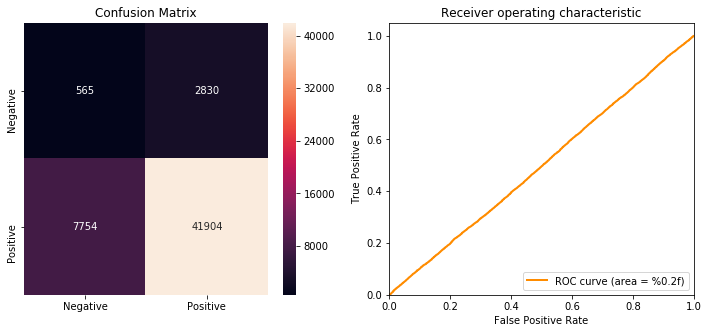

In [45]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Confusion Matrix')
sns.heatmap(df_con,annot=True,fmt='g')
plt.subplot(122)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)')
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### 1.2.2. Pertubation Test

In [49]:
e=np.random.normal(0.03,0.02)

In [50]:
e

0.02416715357579568

In [51]:
final_counts_X1.data+=e


In [52]:
LR1=LogisticRegression(C=0.0001)
LR1.fit(final_counts_X1,y_1)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [53]:
LR1.coef_

array([[-0.00029529,  0.00183665, -0.006702  , ...,  0.00163506,
         0.0003643 ,  0.00506116]])

In [54]:
LR1_W1=LR1.coef_

In [55]:
LR_W1

array([[ 0.00671668,  0.00403491, -0.01857439, ...,  0.00324124,
         0.00023973,  0.012888  ]])

In [56]:
LR_W_Diff = LR_W1-LR1_W1 

Array containing the difference between each term of two coefficient matrices before and after adding impurity

In [57]:
max(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

0.08149656449871504

In [58]:
min(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

3.170893620862026e-08

#### Maximum and minimum difference between coefficient terms are very small. So it can be concluded features are linearly independent

In [59]:
np.mean(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

0.005845506783838765

In [60]:
final_counts_X1.data-=e

#### 1.2.3 Feature importance

In [64]:
coeff_sorted_pos = LR.coef_.argsort()
coeff_neg=-1*(LR.coef_)
coeff_sorted_neg = coeff_neg.argsort()

In [75]:
df1=pd.DataFrame((np.take(count_vect.get_feature_names(), coeff_sorted_pos[:100])).ravel())
df2=pd.DataFrame((np.take(count_vect.get_feature_names(), coeff_sorted_neg[:100])).ravel())

In [87]:
pos_list=[]
for item in df1[0]:
    pos_list.append(item)
neg_list=[]
for item in df2[0]:
    neg_list.append(item)

In [164]:
print("="*43,'Important features for positive class',"="*43)
print("\n")
print(pos_list[:100])
print("\n")
print("\n")
print("="*43,'Important features for negative class',"="*43)
print("\n")
print(neg_list[:100])
print("\n")
print("="*125)


=========================================== Important features for positive class ===========================================


['jitter', 'skewed', 'parking', 'bugles', 'kickin', 'acid', 'wildfire', 'arbitrary', 'affliction', 'vine', 'wisecrackers', 'bowl', 'overnights', 'mid', 'pest', 'cargo', 'shakers', 'litter', 'grays', 'nodoz', 'thickeners', 'pringles', 'liberal', 'busters', 'estatic', 'explains', 'quibbles', 'vanillery', 'prepartion', 'kisser', 'strenuous', 'losses', 'tbs', 'condoms', 'puddings', 'itchiness', 'mysteriously', 'wiskas', 'pitching', 'nine', 'digest', 'hydroponics', 'convent', 'effectiveness', 'speeding', 'artificiality', 'chillis', 'flashing', 'mooccan', 'sizzling', 'pryidoxine', 'vibration', 'overpowered', 'bonsais', 'clicking', 'phu', 'configured', 'chocoperfection', 'smartbalance', 'unpopped', 'path', 'unboxing', 'counties', 'achy', 'bloodhounds', 'savvy', 'diseased', 'damning', 'woolworth', 'pastor', 'faces', 'producers', 'betrayal', 'pearl', 'handier', 'defeat

#### 1.3. RandomizedSearchCV

In [56]:
import scipy

In [57]:
from sklearn.model_selection import RandomizedSearchCV
param_dist={'C':scipy.stats.uniform(10**-4,10**4)}
model2=RandomizedSearchCV(LogisticRegression(),param_dist,scoring='f1',n_jobs=2)
model2.fit(final_counts_X1,y_1)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024DC1CABC50>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [58]:
print(model2.best_estimator_)
print(model2.score(final_counts_Xtest,y_test))

LogisticRegression(C=240.529650814772, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9149273420802356


#### C value got from RandomizedSearchCV is 240.529

#### 1.3.1 Applying Logistic Regression with derived C value

In [90]:
LR=LogisticRegression(C=240.529)
LR.fit(final_counts_X1,y_1)

LogisticRegression(C=240.529, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [91]:
LR.coef_

array([[ 0.0075592 ,  0.00430582, -0.01980931, ...,  0.00344985,
         0.0001931 ,  0.01322784]])

In [92]:
tn,fn,fp,fn=metrics.confusion_matrix(y_test,LR.predict(final_counts_Xtest)).ravel()

In [93]:
prec = metrics.precision_score(y_test,LR.predict(final_counts_Xtest))

In [94]:
recall= metrics.recall_score(y_test,LR.predict(final_counts_Xtest))

In [95]:
f1 = metrics.f1_score(y_test,LR.predict(final_counts_Xtest))

In [96]:
accuracy= metrics.accuracy_score(y_test,LR.predict(final_counts_Xtest))

In [97]:
specificity = tn/float(tn+fp)

In [98]:
neg_pred_value = tn/float(tn+fn)

In [99]:
df1 = pd.DataFrame({'Accuracy Score':[accuracy],'Precision':[prec],'Recall':[recall],'F1_Score':[f1],'Specificity':[specificity],'Negative_Predicted_Value':[neg_pred_value]},index=['BoW_RandomSearch'])

In [100]:
performance_table=performance_table.append(df1)

In [101]:
con_matrix=metrics.confusion_matrix(y_test,LR.predict(final_counts_Xtest))

In [102]:
import seaborn as sns

In [103]:
df_con = pd.DataFrame(con_matrix.T,columns=['Negative','Positive'],index=['Negative','Positive'])

In [104]:
y_pred_prob=LR.predict_proba(final_counts_Xtest)

In [105]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1], pos_label=1)

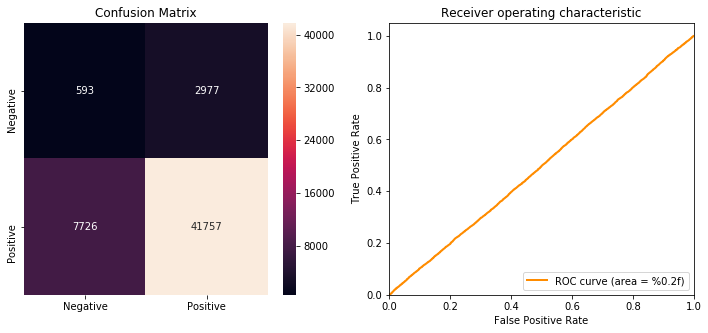

In [106]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Confusion Matrix')
sns.heatmap(df_con,annot=True,fmt='g')
plt.subplot(122)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)')
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### 1.3.2 Pertubation Test

In [107]:
e=np.random.normal(0.03,0.02)

In [108]:
e

0.0545639771095484

In [109]:
final_counts_X1.data+=e


In [110]:
LR1=LogisticRegression(C=240.529)
LR1.fit(final_counts_X1,y_1)

LogisticRegression(C=240.529, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [111]:
LR1.coef_

array([[ 0.00736142,  0.00429513, -0.01929331, ...,  0.00343743,
         0.00067565,  0.01243988]])

In [112]:
LR1_W1=LR1.coef_

In [113]:
LR_W1

array([[ 0.00671668,  0.00403491, -0.01857439, ...,  0.00324124,
         0.00023973,  0.012888  ]])

In [114]:
LR_W_Diff = LR_W1-LR1_W1

In [115]:
max(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

0.06871471285060042

In [116]:
min(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

2.330101308732277e-08

#### Features are linearly independent

#### 1.3.3 Feature importance

In [117]:
coeff_sorted_pos = LR.coef_.argsort()
coeff_neg=-1*(LR.coef_)
coeff_sorted_neg = coeff_neg.argsort()

In [118]:
df1=pd.DataFrame((np.take(count_vect.get_feature_names(), coeff_sorted_pos[:100])).ravel())
df2=pd.DataFrame((np.take(count_vect.get_feature_names(), coeff_sorted_neg[:100])).ravel())

In [119]:
pos_list=[]
for item in df1[0]:
    pos_list.append(item)
neg_list=[]
for item in df2[0]:
    neg_list.append(item)

In [165]:
print("="*43,'Important features for positive class',"="*43)
print("\n")
print(pos_list[:100])
print("\n")
print("\n")
print("="*43,'Important features for negative class',"="*43)
print("\n")
print(neg_list[:100])
print("\n")
print("="*125)


=========================================== Important features for positive class ===========================================


['jitter', 'skewed', 'parking', 'bugles', 'kickin', 'acid', 'wildfire', 'arbitrary', 'affliction', 'vine', 'wisecrackers', 'bowl', 'overnights', 'mid', 'pest', 'cargo', 'shakers', 'litter', 'grays', 'nodoz', 'thickeners', 'pringles', 'liberal', 'busters', 'estatic', 'explains', 'quibbles', 'vanillery', 'prepartion', 'kisser', 'strenuous', 'losses', 'tbs', 'condoms', 'puddings', 'itchiness', 'mysteriously', 'wiskas', 'pitching', 'nine', 'digest', 'hydroponics', 'convent', 'effectiveness', 'speeding', 'artificiality', 'chillis', 'flashing', 'mooccan', 'sizzling', 'pryidoxine', 'vibration', 'overpowered', 'bonsais', 'clicking', 'phu', 'configured', 'chocoperfection', 'smartbalance', 'unpopped', 'path', 'unboxing', 'counties', 'achy', 'bloodhounds', 'savvy', 'diseased', 'damning', 'woolworth', 'pastor', 'faces', 'producers', 'betrayal', 'pearl', 'handier', 'defeat

#### 1.4. L1 regularization

In [23]:
model1 = GridSearchCV(LogisticRegression(penalty='l1'),tuned_parameters,scoring='f1',n_jobs=3)
model1.fit(final_counts_X1,y_1)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid=[{'C': [0.0001, 0.01, 1, 0.01, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [24]:
print(model1.best_estimator_)
print(model1.score(final_counts_Xtest,y_test))

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.915293396033531


#### 1.4.1. C value Vs sparcity

In [25]:
z0=[]
for i in [0.1,0.01,0.001,0.0001]:
    lr = LogisticRegression(C=i,penalty='l1')
    lr.fit(final_counts_X1,y_1)
    w=lr.coef_
    z=np.count_nonzero(w)
    z0.append(z)

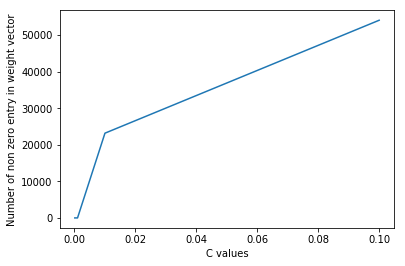

In [67]:
plt.plot([0.1,0.01,0.001,0.0001],z0)
plt.xlabel('C values')
plt.ylabel('Number of non zero entry in weight vector')
plt.show()

In [27]:
z0

[54044, 23169, 0, 0]

#### 1.4.2 C value Vs Error

In [65]:
e0=[]
for i in [0.1,0.01,0.001,0.0001]:
    lr = LogisticRegression(C=i,penalty='l1')
    lr.fit(final_counts_X1,y_1)
    y_pred=lr.predict(X_test)
    error=1-sklearn.metrics.accuracy_score(y_test,y_pred)
    e0.append(error)

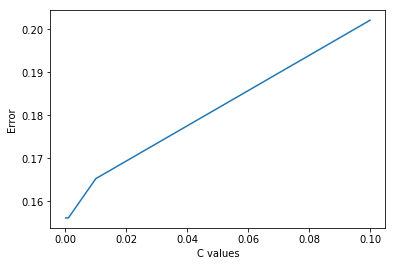

In [69]:
plt.plot([0.1,0.01,0.001,0.0001],e0)
plt.xlabel('C values')
plt.ylabel('Error')
plt.show()

#### 2. Tfidf method

In [121]:
tfidf = TfidfVectorizer()
final_tfidf_X1 = tfidf.fit_transform(X_1)

In [122]:
final_tfidf_Xtest=tfidf.transform(X_test)

#### 2.1 Column Standardization 

In [123]:
colstd1=StandardScaler(with_mean=False)

In [124]:
final_tfidf_X1=colstd1.fit_transform(final_tfidf_X1)

In [125]:
colstd2=StandardScaler(with_mean=False)

In [126]:
final_tfidf_Xtest=colstd2.fit_transform(final_tfidf_Xtest)

In [78]:
tuned_parameters=[{'C':[10**-4,10**-2,10**-0,10**-2,10**4]}]

#### 2.2. GridSearchCV

In [80]:
model = GridSearchCV(LogisticRegression(),tuned_parameters,scoring='f1')
model.fit(final_tfidf_X1,y_1)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 0.01, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [87]:
print(model.best_estimator_)
print(model.score(final_tfidf_Xtest,y_test))

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9149273420802356


C value derived from GridSearchCV is 0.0001

In [128]:
LR=LogisticRegression(C=0.0001)
LR.fit(final_tfidf_X1,y_1)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [129]:
tn,fn,fp,fn=metrics.confusion_matrix(y_test,LR.predict(final_tfidf_Xtest)).ravel()

In [130]:
prec = metrics.precision_score(y_test,LR.predict(final_tfidf_Xtest))

In [131]:
recall= metrics.recall_score(y_test,LR.predict(final_tfidf_Xtest))

In [132]:
f1 = metrics.f1_score(y_test,LR.predict(final_tfidf_Xtest))

In [133]:
accuracy= metrics.accuracy_score(y_test,LR.predict(final_tfidf_Xtest))

In [134]:
specificity = tn/float(tn+fp)

In [135]:
neg_pred_value = tn/float(tn+fn)

In [136]:
df2 = pd.DataFrame({'Accuracy Score':[accuracy],'Precision':[prec],'Recall':[recall],'F1_Score':[f1],'Specificity':[specificity],'Negative_Predicted_Value':[neg_pred_value]},index=['Tfidf_GridSearch'])

In [137]:
performance_table=performance_table.append(df2)

In [138]:
performance_table

,Accuracy Score,Precision,Recall,F1_Score,Specificity,Negative_Predicted_Value
BoW_GridSearch,0.800501,0.843852,0.936737,0.887872,0.166421,0.013304
BoW_RandomSearch,0.798258,0.843866,0.933451,0.886401,0.166106,0.014002
Tfidf_GridSearch,0.830094,0.843475,0.980440,0.906815,0.170616,0.004087


In [139]:
con_matrix=metrics.confusion_matrix(y_test,LR.predict(final_tfidf_Xtest))

In [140]:
import seaborn as sns

In [141]:
df_con = pd.DataFrame(con_matrix.T,columns=['Negative','Positive'],index=['Negative','Positive'])

In [142]:
y_pred_prob=LR.predict_proba(final_counts_Xtest)

In [143]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1], pos_label=1)

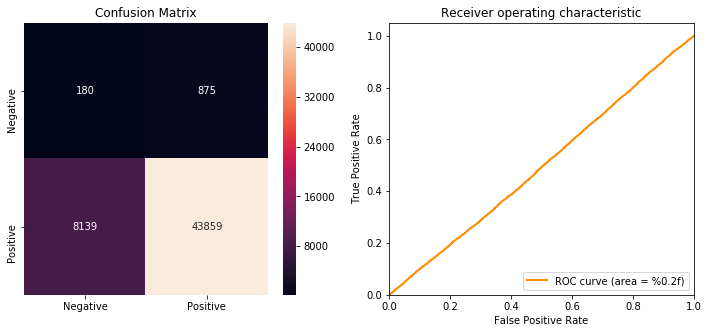

In [144]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Confusion Matrix')
sns.heatmap(df_con,annot=True,fmt='g')
plt.subplot(122)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)')
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### 2.2.1 Applying Logistic Regression with derived C value

In [145]:
LR=LogisticRegression(C=0.0001)
LR.fit(final_tfidf_X1,y_1)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [146]:
LR.coef_

array([[ 0.00083816,  0.00210002, -0.00707396, ...,  0.00156621,
         0.00054903,  0.00458001]])

In [147]:
LR_W1=LR.coef_

#### 2.2.2 Pertubation Test

In [148]:
e=np.random.normal(0.03,0.02)

In [149]:
e

0.023344580341622224

In [150]:
final_tfidf_X1.data+=e

In [151]:
LR1=LogisticRegression(C=0.0001)
LR1.fit(final_tfidf_X1,y_1)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [152]:
LR1.coef_

array([[ 0.00083297,  0.00210082, -0.00707503, ...,  0.00156576,
         0.00054907,  0.00458528]])

In [153]:
LR1_W1=LR1.coef_

In [154]:
LR_W1

array([[ 0.00083816,  0.00210002, -0.00707396, ...,  0.00156621,
         0.00054903,  0.00458001]])

In [155]:
LR_W_Diff = LR_W1-LR1_W1

In [156]:
max(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

0.00020789773820374668

In [157]:
min(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

7.38303446157218e-11

In [158]:
np.mean(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

2.7804357447168e-06

In [159]:
final_tfidf_X1.data-=e

#### Features are linearly independent

#### 2.2.3 Feature Importance

In [160]:
coeff_sorted_pos = LR.coef_.argsort()
coeff_neg=-1*(LR.coef_)
coeff_sorted_neg = coeff_neg.argsort()

In [161]:
df1=pd.DataFrame((np.take(count_vect.get_feature_names(), coeff_sorted_pos[:100])).ravel())
df2=pd.DataFrame((np.take(count_vect.get_feature_names(), coeff_sorted_neg[:100])).ravel())

In [162]:
pos_list=[]
for item in df1[0]:
    pos_list.append(item)
neg_list=[]
for item in df2[0]:
    neg_list.append(item)

In [166]:
print("="*43,'Important features for positive class',"="*43)
print("\n")
print(pos_list[:100])
print("\n")
print("\n")
print("="*43,'Important features for negative class',"="*43)
print("\n")
print(neg_list[:100])
print("\n")
print("="*125)


=========================================== Important features for positive class ===========================================


['jitter', 'skewed', 'parking', 'bugles', 'kickin', 'acid', 'wildfire', 'arbitrary', 'affliction', 'vine', 'wisecrackers', 'bowl', 'overnights', 'mid', 'pest', 'cargo', 'shakers', 'litter', 'grays', 'nodoz', 'thickeners', 'pringles', 'liberal', 'busters', 'estatic', 'explains', 'quibbles', 'vanillery', 'prepartion', 'kisser', 'strenuous', 'losses', 'tbs', 'condoms', 'puddings', 'itchiness', 'mysteriously', 'wiskas', 'pitching', 'nine', 'digest', 'hydroponics', 'convent', 'effectiveness', 'speeding', 'artificiality', 'chillis', 'flashing', 'mooccan', 'sizzling', 'pryidoxine', 'vibration', 'overpowered', 'bonsais', 'clicking', 'phu', 'configured', 'chocoperfection', 'smartbalance', 'unpopped', 'path', 'unboxing', 'counties', 'achy', 'bloodhounds', 'savvy', 'diseased', 'damning', 'woolworth', 'pastor', 'faces', 'producers', 'betrayal', 'pearl', 'handier', 'defeat

#### 2.3. RandomizedSearch

In [107]:
from sklearn.model_selection import RandomizedSearchCV
param_dist={'C':scipy.stats.uniform(10**-4,10**4)}
model2=RandomizedSearchCV(LogisticRegression(),param_dist,scoring='f1',n_jobs=2)
model2.fit(final_tfidf_X1,y_1)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024DD1915C50>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [108]:
print(model2.best_estimator_)
print(model2.score(final_tfidf_Xtest,y_test))

LogisticRegression(C=1988.7648045521228, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9149273420802356


#### 2.3.1 Applying Logistic Regression with derived C value

In [167]:
LR=LogisticRegression(C=1988.764)
LR.fit(final_tfidf_X1,y_1)

LogisticRegression(C=1988.764, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [168]:
tn,fn,fp,fn=metrics.confusion_matrix(y_test,LR.predict(final_tfidf_Xtest)).ravel()

In [169]:
prec = metrics.precision_score(y_test,LR.predict(final_tfidf_Xtest))

In [170]:
recall= metrics.recall_score(y_test,LR.predict(final_tfidf_Xtest))

In [171]:
f1 = metrics.f1_score(y_test,LR.predict(final_tfidf_Xtest))

In [172]:
accuracy= metrics.accuracy_score(y_test,LR.predict(final_tfidf_Xtest))

In [173]:
specificity = tn/float(tn+fp)

In [174]:
neg_pred_value = tn/float(tn+fn)

In [175]:
df3 = pd.DataFrame({'Accuracy Score':[accuracy],'Precision':[prec],'Recall':[recall],'F1_Score':[f1],'Specificity':[specificity],'Negative_Predicted_Value':[neg_pred_value]},index=['Tfidf_RandomSearch'])

In [176]:
performance_table=performance_table.append(df3)

In [177]:
performance_table

,Accuracy Score,Precision,Recall,F1_Score,Specificity,Negative_Predicted_Value
BoW_GridSearch,0.800501,0.843852,0.936737,0.887872,0.166421,0.013304
BoW_RandomSearch,0.798258,0.843866,0.933451,0.886401,0.166106,0.014002
Tfidf_GridSearch,0.830094,0.843475,0.980440,0.906815,0.170616,0.004087
Tfidf_RandomSearch,0.802273,0.843333,0.940157,0.889117,0.158970,0.011888


In [178]:
con_matrix=metrics.confusion_matrix(y_test,LR.predict(final_tfidf_Xtest))

In [179]:
import seaborn as sns

In [180]:
df_con = pd.DataFrame(con_matrix.T,columns=['Negative','Positive'],index=['Negative','Positive'])

In [181]:
y_pred_prob=LR.predict_proba(final_counts_Xtest)

In [182]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1], pos_label=1)

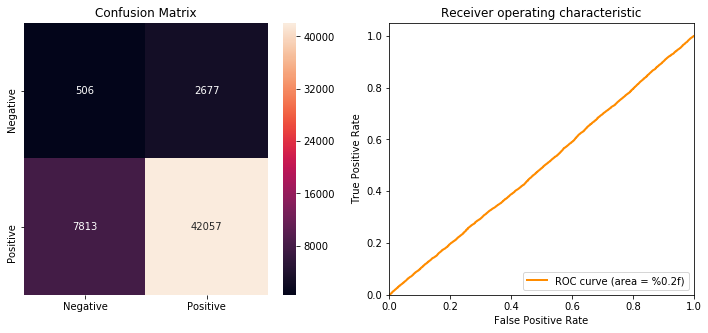

In [183]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Confusion Matrix')
sns.heatmap(df_con,annot=True,fmt='g')
plt.subplot(122)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)')
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [184]:
LR.coef_

array([[ 0.00770199,  0.00522726, -0.01702975, ...,  0.00338498,
         0.00099486,  0.01238445]])

In [185]:
LR_W1=LR.coef_

In [186]:
coeff_sorted = LR.coef_.argsort()

#### 2.3.2 Pertubation Test

In [187]:
e=np.random.normal(0.03,0.02)

In [188]:
e

0.05375132344285757

In [189]:
final_tfidf_X1.data+=e

In [190]:
LR1=LogisticRegression(C=0.0001)
LR1.fit(final_tfidf_X1,y_1)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [191]:
LR1.coef_

array([[ 0.0008246 ,  0.00210184, -0.00707645, ...,  0.00156521,
         0.00054914,  0.00459186]])

In [192]:
LR1_W1=LR1.coef_

In [193]:
LR_W1

array([[ 0.00770199,  0.00522726, -0.01702975, ...,  0.00338498,
         0.00099486,  0.01238445]])

In [194]:
LR_W_Diff = LR_W1-LR1_W1

In [195]:
max(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

0.056900231328664695

In [196]:
min(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

5.567557262689169e-08

#### Features are linearly independent

#### 2.3.3 Feature Importance

In [197]:
coeff_sorted_pos = LR.coef_.argsort()
coeff_neg=-1*(LR.coef_)
coeff_sorted_neg = coeff_neg.argsort()

In [198]:
df1=pd.DataFrame((np.take(count_vect.get_feature_names(), coeff_sorted_pos[:100])).ravel())
df2=pd.DataFrame((np.take(count_vect.get_feature_names(), coeff_sorted_neg[:100])).ravel())

In [199]:
pos_list=[]
for item in df1[0]:
    pos_list.append(item)
neg_list=[]
for item in df2[0]:
    neg_list.append(item)

In [200]:
print("="*43,'Important features for positive class',"="*43)
print("\n")
print(pos_list[:100])
print("\n")
print("\n")
print("="*43,'Important features for negative class',"="*43)
print("\n")
print(neg_list[:100])
print("\n")
print("="*125)


=========================================== Important features for positive class ===========================================


['jitter', 'skewed', 'artificiality', 'krueig', 'unseal', 'dehydrogenate', 'plantings', 'wildfire', 'arbitrary', 'voraciously', 'nat', 'foliage', 'unboxing', 'affliction', 'wisecrackers', 'grays', 'yap', 'baldwin', 'marlene', 'ellie', 'edta', 'dosages', 'poisen', 'nodoz', 'kickin', 'woolworth', 'cargo', 'imposter', 'connects', 'welfare', 'glasgow', 'lifestyles', 'mehmet', 'headquarters', 'flashing', 'tulley', 'sizzling', 'coasts', 'longish', 'overnights', 'spiedie', 'frighten', 'clicking', 'octagonal', 'diseased', 'industries', 'postulates', 'jot', 'catchiest', 'accordion', 'chicka', 'dimished', 'supped', 'frolicksome', 'whoopy', 'yukkin', 'bangled', 'gusty', 'baubled', 'sag', 'lanai', 'journals', 'kisser', 'chocoperfection', 'supervising', 'nastier', 'losses', 'cooties', 'growled', 'introductions', 'hani', 'towelsls', 'kolibri', 'wilsonara', 'sharry', 'catata

#### 2.4 L1 Regularization

In [132]:
X_train.data-=e

In [133]:
model1 = GridSearchCV(LogisticRegression(penalty='l1'),tuned_parameters,scoring='f1',n_jobs=1)
model1.fit(final_tfidf_X1,y_1)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 0.01, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [134]:
print(model1.best_estimator_)
print(model1.score(final_tfidf_Xtest,y_test))

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.915293396033531


#### 2.4.1. C value Vs sparcity

In [135]:
z0=[]
for i in [0.1,0.01,0.001,0.0001]:
    lr = LogisticRegression(C=i,penalty='l1')
    lr.fit(final_tfidf_X1,y_1)
    w=lr.coef_
    z=np.count_nonzero(w)
    z0.append(z)

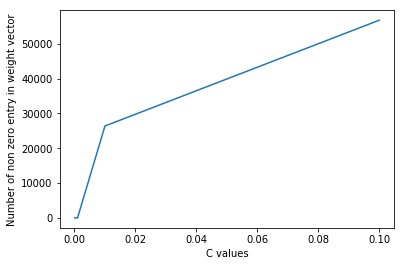

In [136]:
plt.plot([0.1,0.01,0.001,0.0001],z0)
plt.xlabel('C values')
plt.ylabel('Number of non zero entry in weight vector')
plt.show()

In [137]:
z0

[56775, 26401, 0, 0]

#### 2.4.2 C value Vs Error

In [138]:
e0=[]
for i in [0.1,0.01,0.001,0.0001]:
    lr = LogisticRegression(C=i,penalty='l1')
    lr.fit(final_tfidf_X1,y_1)
    y_pred=lr.predict(final_tfidf_X1)
    error=1-sklearn.metrics.accuracy_score(y_test,y_pred)
    e0.append(error)

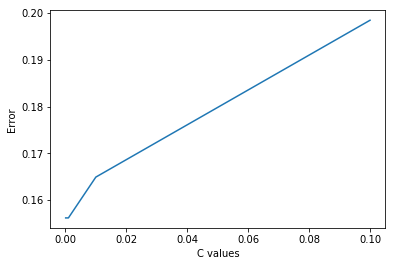

In [139]:
plt.plot([0.1,0.01,0.001,0.0001],e0)
plt.xlabel('C values')
plt.ylabel('Error')
plt.show()

#### 3.Average Word2Vec

In [201]:
import gensim


C:\Users\Dipayan\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [202]:
list_of_sent_X1 = []
for sent in X_1:
    filtered_sentance=[]
    for w in sent.split():
        filtered_sentance.append(w)
    list_of_sent_X1.append(filtered_sentance)

In [203]:
W2V=gensim.models.Word2Vec(list_of_sent_X1,min_count=5,size=50,workers=4)

In [204]:
sent_vectors_X1 = []
for sent in list_of_sent_X1:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = W2V.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    if cnt_words==0:
        sent_vectors_X1.append(np.zeros(50))
    else:
        sent_vectors_X1.append(sent_vec)

C:\Users\Dipayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [205]:
df_X1=pd.DataFrame(sent_vectors_X1)

In [206]:
df_X1.shape

(212212, 50)

In [207]:
y_1.shape

(212212,)

In [208]:
tuned_parameters=[{'C':[10**-4,10**-2,10**-0,10**-2,10**4]}]

#### 3.1 GridSearchCV

In [27]:
model = GridSearchCV(LogisticRegression(),tuned_parameters,scoring='f1')
model.fit(df_X1,y_1)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 0.01, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [209]:
list_of_sent_Xtest = []
for sent in X_test:
    filtered_sentance=[]
    for w in sent.split():
        filtered_sentance.append(w)
    list_of_sent_Xtest.append(filtered_sentance)

In [210]:
sent_vectors_Xtest = []
for sent in list_of_sent_Xtest:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = W2V.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    if cnt_words==0:
        sent_vectors_Xtest.append(np.zeros(50))
    else:
        sent_vectors_Xtest.append(sent_vec)

In [211]:
df_Xtest=pd.DataFrame(sent_vectors_Xtest)

In [212]:
df_Xtest.shape

(53053, 50)

In [213]:
y_test.shape

(53053,)

#### 3.1.1 Applying Logistic Regreession with derived C value

In [33]:
print(model.best_estimator_)
print(model.score(df_Xtest,y_test))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9149273420802356


In [215]:
LR=LogisticRegression(C=0.01)
LR.fit(df_X1,y_1)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [225]:
LR_W1=LR.coef_

#### 3.1.2 Pertubation test

In [216]:
e=np.random.normal(0.03,0.02)

In [217]:
e

0.03528593892553734

In [218]:
df_X1+=e

In [219]:
LR1=LogisticRegression(C=0.01)
LR1.fit(df_X1,y_1)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [220]:
LR1.coef_

array([[-0.19297889,  0.08302256, -0.00473971, -0.06256505,  0.04654224,
        -0.04844516,  0.08260284,  0.12275499, -0.07247556,  0.10692215,
        -0.08449578,  0.10396052,  0.02771107, -0.15820681,  0.03754616,
         0.16174   , -0.10368227, -0.07484519,  0.17166268,  0.07492807,
         0.01284445, -0.00877333,  0.0416666 ,  0.08690573,  0.07036047,
         0.11662243,  0.00546516,  0.0175725 , -0.02947146,  0.15978862,
         0.15528429, -0.07857542,  0.05060631,  0.12737115,  0.15188312,
         0.00152423, -0.04789635, -0.07620724, -0.05566998, -0.13191665,
        -0.19451543,  0.02861704, -0.00142713, -0.09164076, -0.00983358,
        -0.02441553,  0.00445978,  0.00032717, -0.06286939,  0.07575386]])

In [221]:
LR1_W1=LR1.coef_

In [222]:
df_X1-=e

In [223]:
LR_W1

array([[ 0.00770199,  0.00522726, -0.01702975, ...,  0.00338498,
         0.00099486,  0.01238445]])

In [226]:
LR_W_Diff = LR_W1-LR1_W1

In [227]:
np.mean(np.absolute(LR_W_Diff))

0.0008850556576551344

In [228]:
np.max(np.absolute(LR_W_Diff))

0.002331921827883443

#### 3.2 L1 Regularization

In [54]:
model1 = GridSearchCV(LogisticRegression(penalty='l1'),tuned_parameters,scoring='f1',n_jobs=3)
model1.fit(df_X1,y_1)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid=[{'C': [0.0001, 0.01, 1, 0.01, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [55]:
print(model1.best_estimator_)
print(model1.score(df_Xtest,y_test))

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9149273420802356


#### 3.2.1 C Vs Sparcity

In [64]:
from sklearn.metrics import accuracy_score

In [38]:
import matplotlib.pyplot as plt

In [59]:
z0=[]
for i in [0.1,0.01,0.001,0.0001]:
    lr = LogisticRegression(C=i,penalty='l1')
    lr.fit(df_X1,y_1)
    w=lr.coef_
    z=np.count_nonzero(w)
    z0.append(z)

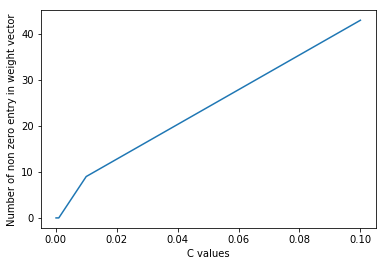

In [60]:
plt.plot([0.1,0.01,0.001,0.0001],z0)
plt.xlabel('C values')
plt.ylabel('Number of non zero entry in weight vector')
plt.show()

#### 3.2.2 C Vs Error

In [35]:
from sklearn import metrics

In [61]:
z0

[43, 9, 0, 0]

In [43]:
e0=[]
for i in [0.1,0.01,0.001,0.0001]:
    lr = LogisticRegression(C=i,penalty='l1')
    lr.fit(df_X1,y_1)
    y_pred=lr.predict(df_Xtest)
    print(metrics.accuracy_score(y_test,y_pred))
    e0.append((1-metrics.accuracy_score(y_test,y_pred)))

0.8431945413077488
0.8431945413077488
0.8431945413077488
0.8431945413077488


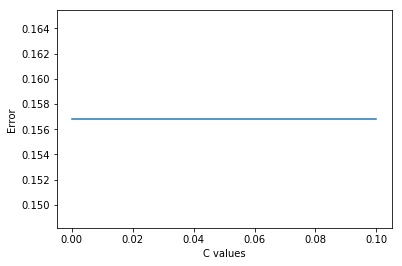

In [45]:
plt.plot([0.1,0.01,0.001,0.0001],e0)
plt.xlabel('C values')
plt.ylabel('Error')
plt.show()

In [229]:
LR=LogisticRegression(C=0.000001)
LR.fit(df_X1,y_1)

LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [230]:
tn,fn,fp,fn=metrics.confusion_matrix(y_test,LR.predict(df_Xtest)).ravel()

In [231]:
prec = metrics.precision_score(y_test,LR.predict(df_Xtest))

In [232]:
recall= metrics.recall_score(y_test,LR.predict(df_Xtest))

In [233]:
f1 = metrics.f1_score(y_test,LR.predict(df_Xtest))

In [234]:
accuracy= metrics.accuracy_score(y_test,LR.predict(df_Xtest))

In [235]:
specificity = tn/float(tn+fp)

In [236]:
neg_pred_value = tn/float(tn+fn)

In [237]:
df4 = pd.DataFrame({'Accuracy Score':[accuracy],'Precision':[prec],'Recall':[recall],'F1_Score':[f1],'Specificity':[specificity],'Negative_Predicted_Value':[neg_pred_value]},index=['W2V_avg'])

In [238]:
performance_table=performance_table.append(df4)

In [239]:
performance_table

,Accuracy Score,Precision,Recall,F1_Score,Specificity,Negative_Predicted_Value
BoW_GridSearch,0.800501,0.843852,0.936737,0.887872,0.166421,0.013304
BoW_RandomSearch,0.798258,0.843866,0.933451,0.886401,0.166106,0.014002
Tfidf_GridSearch,0.830094,0.843475,0.980440,0.906815,0.170616,0.004087
Tfidf_RandomSearch,0.802273,0.843333,0.940157,0.889117,0.158970,0.011888
W2V_avg,0.842855,0.843154,0.999575,0.914726,0.050000,0.000022


In [240]:
con_matrix=metrics.confusion_matrix(y_test,LR.predict(df_Xtest))

In [241]:
import seaborn as sns

In [242]:
df_con = pd.DataFrame(con_matrix.T,columns=['Negative','Positive'],index=['Negative','Positive'])

In [243]:
y_pred_prob=LR.predict_proba(df_Xtest)

In [244]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1], pos_label=1)

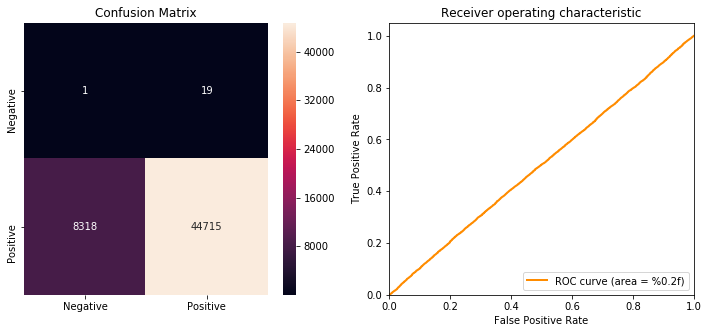

In [245]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Confusion Matrix')
sns.heatmap(df_con,annot=True,fmt='g')
plt.subplot(122)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)')
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### 4. Tfidf Word2Vec

In [246]:
from sklearn.utils import resample

In [247]:
finaldf1=resample(final_df,n_samples=10000)

In [248]:
X=finaldf1[0].values
y=finaldf1["Score"].values

In [249]:
X_1=X[0:8000]
y_1=y[0:8000]
X_test=X[8000:10000]
y_test=y[8000:10000]

In [250]:
tfidf = TfidfVectorizer()
final_tfidf = tfidf.fit_transform(X)

In [251]:
list_of_sent_X1 = []
for sent in X_1:
    filtered_sentance=[]
    for w in sent.split():
        filtered_sentance.append(w)
    list_of_sent_X1.append(filtered_sentance)

In [252]:
tfidf_sent_vectors_X1 = []
tfidf_feat = tfidf.get_feature_names()
i=0
for sent in list_of_sent_X1: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0.0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = W2V.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tfidf[i, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    tfidf_sent_vec = sent_vec/weight_sum
    tfidf_sent_vectors_X1.append(tfidf_sent_vec)
    i += 1

In [253]:
df_X1=pd.DataFrame(tfidf_sent_vectors_X1)


In [254]:
df_X1.shape

(8000, 50)

In [62]:
tuned_parameters=[{'C':[10**-4,10**-2,10**-0,10**-2,10**4]}]

#### 4.1 GridSearchCV

In [63]:
model = GridSearchCV(LogisticRegression(),tuned_parameters,scoring='f1')
model.fit(df_X1,y_1)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 0.01, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [255]:
list_of_sent_Xtest = []
for sent in X_test:
    filtered_sentance=[]
    for w in sent.split():
        filtered_sentance.append(w)
    list_of_sent_Xtest.append(filtered_sentance)

In [256]:
tfidf_sent_vectors_Xtest = []
tfidf_feat = tfidf.get_feature_names()
i=0
for sent in list_of_sent_Xtest: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0.0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = W2V.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tfidf[i, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    tfidf_sent_vec = sent_vec/weight_sum
    if weight_sum==0:
        tfidf_sent_vectors_Xtest.append(np.zeros(50))
    else:
        tfidf_sent_vectors_Xtest.append(tfidf_sent_vec)
    i += 1

C:\Users\Dipayan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [257]:
df_Xtest=pd.DataFrame(tfidf_sent_vectors_Xtest)

In [258]:
df_Xtest.shape

(2000, 50)

In [70]:
print(model.best_estimator_)
print(model.score(df_Xtest,y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9046965119472671


In [72]:
model1 = GridSearchCV(LogisticRegression(penalty='l1'),tuned_parameters,scoring='f1',n_jobs=3)
model1.fit(df_X1,y_1)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid=[{'C': [0.0001, 0.01, 1, 0.01, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [73]:
print(model1.best_estimator_)
print(model1.score(df_Xtest,y_test))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9136338946224878


#### 4.1.1 Applying Logistic Regression with best C

In [259]:
LR=LogisticRegression(C=0.0001)
LR.fit(df_X1,y_1)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [260]:
tn,fn,fp,fn=metrics.confusion_matrix(y_test,LR.predict(df_Xtest)).ravel()

In [261]:
prec = metrics.precision_score(y_test,LR.predict(df_Xtest))

In [262]:
recall= metrics.recall_score(y_test,LR.predict(df_Xtest))

In [263]:
f1 = metrics.f1_score(y_test,LR.predict(df_Xtest))

In [264]:
accuracy= metrics.accuracy_score(y_test,LR.predict(df_Xtest))

In [265]:
specificity = tn/float(tn+fp)

In [266]:
neg_pred_value = tn/float(tn+fn)

In [267]:
df5 = pd.DataFrame({'Accuracy Score':[accuracy],'Precision':[prec],'Recall':[recall],'F1_Score':[f1],'Specificity':[specificity],'Negative_Predicted_Value':[neg_pred_value]},index=['W2V_tfidf'])

In [268]:
performance_table=performance_table.append(df5)

In [269]:
performance_table

,Accuracy Score,Precision,Recall,F1_Score,Specificity,Negative_Predicted_Value
BoW_GridSearch,0.800501,0.843852,0.936737,0.887872,0.166421,0.013304
BoW_RandomSearch,0.798258,0.843866,0.933451,0.886401,0.166106,0.014002
Tfidf_GridSearch,0.830094,0.843475,0.980440,0.906815,0.170616,0.004087
Tfidf_RandomSearch,0.802273,0.843333,0.940157,0.889117,0.158970,0.011888
W2V_avg,0.842855,0.843154,0.999575,0.914726,0.050000,0.000022
W2V_tfidf,0.836000,0.838435,0.996422,0.910627,0.142857,0.000598


In [270]:
con_matrix=metrics.confusion_matrix(y_test,LR.predict(df_Xtest))

In [271]:
import seaborn as sns

In [272]:
df_con = pd.DataFrame(con_matrix.T,columns=['Negative','Positive'],index=['Negative','Positive'])

In [273]:
y_pred_prob=LR.predict_proba(df_Xtest)

In [274]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1], pos_label=1)

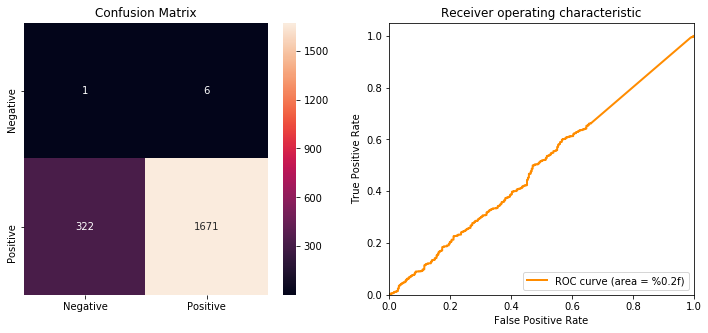

In [275]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Confusion Matrix')
sns.heatmap(df_con,annot=True,fmt='g')
plt.subplot(122)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)')
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [276]:
LR.coef_

array([[-7.77882539e-02, -4.65097783e-02,  7.08634188e-06,
        -1.04274182e-02, -1.66797802e-02, -3.32341038e-04,
         2.04101375e-03,  1.32657545e-02, -1.10970790e-02,
         7.57020147e-03, -1.41604035e-02, -6.54236835e-03,
        -2.76824954e-02, -3.03249634e-02, -4.85039917e-02,
         3.33958408e-02, -5.78217454e-02, -2.42602686e-02,
         4.59385857e-02,  5.47554603e-02,  2.15826570e-02,
        -7.13225968e-02, -4.54172492e-02,  6.47314912e-02,
         2.74273756e-02,  2.08034463e-02,  7.24480216e-02,
        -3.34731197e-02,  2.63141178e-02,  1.23431897e-02,
         7.85558594e-02, -1.96399057e-02,  2.85465079e-02,
         4.11006773e-02,  2.67496194e-02,  4.05933997e-02,
        -4.34007659e-02,  3.63177481e-02,  2.18132019e-02,
        -9.85048617e-03, -6.03567616e-02, -2.61195469e-03,
         7.38286567e-03,  3.48703640e-04,  4.93034453e-02,
         2.57752250e-02, -1.48632140e-02, -4.39300015e-03,
         5.72146144e-02,  6.07096779e-02]])

In [277]:
LR_W1=LR.coef_

In [278]:
coeff_sorted = LR.coef_.argsort()

#### 4.1.2 Pertubation test

In [280]:
e=np.random.normal(0.03,0.02)

In [281]:
e

0.035876415566049244

In [282]:
df_X1+=e

In [283]:
LR1=LogisticRegression(C=0.0001)
LR1.fit(df_X1,y_1)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [284]:
LR1.coef_

array([[-0.07200137, -0.04165145,  0.00445106, -0.00524686, -0.01158557,
         0.00407071,  0.00621794,  0.01766796, -0.00618363,  0.01215455,
        -0.00967536, -0.00179846, -0.02332415, -0.02508908, -0.04285368,
         0.03741228, -0.05312882, -0.01938446,  0.04959898,  0.05840579,
         0.02678978, -0.06583143, -0.04030218,  0.06875766,  0.03149715,
         0.02516015,  0.07636657, -0.02801044,  0.03076668,  0.01751598,
         0.08233949, -0.01464199,  0.03307892,  0.0456806 ,  0.03112657,
         0.04466819, -0.03809792,  0.04076001,  0.02570744, -0.00513407,
        -0.05467123,  0.00198351,  0.01221075,  0.00529025,  0.05315428,
         0.03012576, -0.00923508,  0.00036502,  0.06087761,  0.06465505]])

In [285]:
LR1_W1=LR1.coef_

In [286]:
LR_W_Diff = LR_W1-LR1_W1

In [287]:
import numpy as np

In [288]:
max(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

0.005786883110709143

In [289]:
min(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

0.003650333729580929

In [290]:
np.mean(np.absolute(LR_W_Diff[LR_W_Diff!=0]))

0.00462867205611472

#### 4.2.1 C vs Sparcity

In [93]:
z0=[]
for i in [0.1,0.01,0.001,0.0001]:
    lr = LogisticRegression(C=i,penalty='l1')
    lr.fit(df_X1,y_1)
    w=lr.coef_
    z=np.count_nonzero(w)
    z0.append(z)

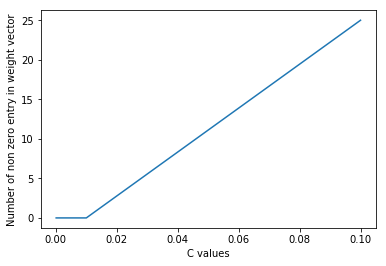

In [94]:
plt.plot([0.1,0.01,0.001,0.0001],z0)
plt.xlabel('C values')
plt.ylabel('Number of non zero entry in weight vector')
plt.show()

#### 4.2.2 C vs Error

In [96]:
e0=[]
for i in [0.1,0.01,0.001,0.0001]:
    lr = LogisticRegression(C=i,penalty='l1')
    lr.fit(df_X1,y_1)
    y_pred=lr.predict(df_Xtest)
    print(metrics.accuracy_score(y_test,y_pred))
    e0.append((1-metrics.accuracy_score(y_test,y_pred)))

0.841
0.841
0.841
0.159


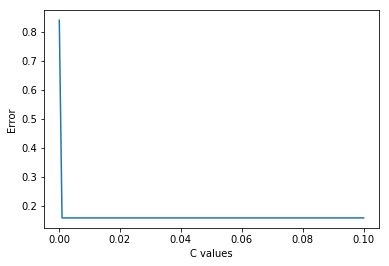

In [97]:
plt.plot([0.1,0.01,0.001,0.0001],e0)
plt.xlabel('C values')
plt.ylabel('Error')
plt.show()

#### Summary
- Dataset was loaded
- Whole set was sorted based on time
- Pre processing on Text data was performed
- Whole set was splitted into two parts, 80% training set, 20% test set
- Tried Bag of Words, Tfidf, Average Word2Vec and Tfidf Word2Vec. For each method following steps are performed
 - Column Standardization
 - GridSearchCV and RandomizedCV
 - Applied Logistic Regression with derived C values
 - Pertubation Test
 - Feature Importance
 - L1 Regularization
 - C Vs Sparcity
 - C Vs Error

In [297]:
print("="*35,'performance_table',"="*35)
display(performance_table)
print("="*92)

=================================== performance_table ===================================


,Accuracy Score,Precision,Recall,F1_Score,Specificity,Negative_Predicted_Value
BoW_GridSearch,0.800501,0.843852,0.936737,0.887872,0.166421,0.013304
BoW_RandomSearch,0.798258,0.843866,0.933451,0.886401,0.166106,0.014002
Tfidf_GridSearch,0.830094,0.843475,0.980440,0.906815,0.170616,0.004087
Tfidf_RandomSearch,0.802273,0.843333,0.940157,0.889117,0.158970,0.011888
W2V_avg,0.842855,0.843154,0.999575,0.914726,0.050000,0.000022
W2V_tfidf,0.836000,0.838435,0.996422,0.910627,0.142857,0.000598
